In [1]:
google_colab = False

# Google Colab用事前準備

In [2]:
# install
try:
    import binarybrain as bb
except:
    if google_colab and False:
        !pip install pybind11
        %cd /content
        !nvcc -V
        !sudo rm -fr BinaryBrain
        !rm -fr BinaryBrain
        !git clone --recursive -b ver3_develop https://github.com/ryuz/BinaryBrain.git
        %cd /content/BinaryBrain/python
        !sh copy_src.sh
        !python3 setup.py build
        !python3 setup.py develop

        import binarybrain as bb

In [3]:
# mount
if google_colab:
  from google.colab import drive 
  drive.mount('/content/drive')
  %cd /content/drive/My Drive/git-work/BinaryBrain_ver3_develop/tests/python

In [4]:
device = 0

import binarybrain as bb

import importlib
importlib.reload(bb)

bb.set_device(device)
prop = bb.get_device_properties(device)
print(prop)


name                     : GeForce GTX 1660 SUPER
totalGlobalMem           : 6442450944
sharedMemPerBlock        : 49152
regsPerBlock             : 65536
warpSize                 : 32
memPitch                 : 2147483647
maxThreadsPerBlock       : 1024
maxThreadsDim[0]         : 1024
maxThreadsDim[1]         : 1024
maxThreadsDim[2]         : 64
maxGridSize[0]           : 2147483647
maxGridSize[1]           : 65535
maxGridSize[2]           : 65535
clockRate                : 1800000
totalConstMem            : 65536
major                    : 7
minor                    : 5
textureAlignment         : 512
deviceOverlap            : 1
multiProcessorCount      : 22
kernelExecTimeoutEnabled : 1
integrated               : 0
canMapHostMemory         : 1
computeMode              : 0




# メインコード

In [5]:
import binarybrain as bb
import numpy as np
import os
import sys
import random
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from collections import OrderedDict

In [6]:
#from os.path import expanduser
import glob

home_path = os.path.expanduser("~")
bg_image_path  = os.path.join(home_path, ".binarybrain", "dataset", "coco", "val2017", "*.jpg")
bg_image_files = glob.glob(bg_image_path)

In [7]:
def get_random_bg_image(w, h):
    img = cv2.imread(random.choice(bg_image_files))[:,:,::-1].astype(np.float32) / 255
    y = random.randrange(img.shape[0] - h)
    x = random.randrange(img.shape[1] - w)
    roi = img[y:y+h,x:x+w,:]
    return roi.transpose(2, 0, 1).reshape(3, -1)

In [8]:
def make_bg_image(x, t, bk):
    x_img      = bk.reshape(3,  28*28)
    detect_img = np.zeros((1,  28*28), dtype=np.float32)
    class_img  = np.zeros((10, 28*28), dtype=np.float32)
    mask0 = x <= 0.5
    mask1 = x > 0.5
    for j in range(3):
        x_img[j,mask1] = random.random()
    detect_img[0,mask1] = 1.0
    for j in range(10):
        class_img[j,mask1] = t[j]
    return x_img, detect_img, class_img

In [9]:
def marge_bg_image(x, w, h):
    bk  = get_random_bg_image(w, h)
    img = np.ndarray((3, h*w), dtype=np.float32)
    for i in range(3):
        img[i] = random.random()
        img[i] = img[i] * x + bk[i] * (1 - x)
    return img

In [10]:
def make_test_image(src_x, src_t):
    dst_x = np.ndarray((len(src_x),  1, 28, 28), dtype=np.float32)
    dst_t = np.ndarray((len(src_x), 11, 28, 28), dtype=np.float32)
    for i in range(len(src_x)):
        x_img = src_x[i].copy()
        t_img = np.zeros((11, 28*28), dtype=np.float32)
        mask0 = x_img <= 0.5
        mask1 = x_img > 0.5
        for j in range(10):
            t_img[j,mask1] = src_t[i][j]
        t_img[10,mask0] = 0.15
        dst_x[i] = x_img.reshape(1, 28, 28)
        dst_t[i] = t_img.reshape(11, 28, 28)
    return dst_x, dst_t

def make_test_data(src_x, src_t):
    x, t = make_test_image(src_x, src_t)

    dst_x = np.ndarray((len(src_x) // 4,  1*56*56), dtype=np.float32)
    dst_t = np.ndarray((len(src_x) // 4, 11*56*56), dtype=np.float32)
    for i in range(len(x) // 4):
        x_img = np.hstack((np.dstack((x[i*4+0], x[i*4+1])), np.dstack((x[i*4+2], x[i*4+3]))))
        t_img = np.hstack((np.dstack((t[i*4+0], t[i*4+1])), np.dstack((t[i*4+2], t[i*4+3]))))
        dst_x[i] = x_img.reshape(-1)
        dst_t[i] = t_img.reshape(-1)
    return dst_x, dst_t

def image_transform(img):
    angle = random.uniform(-10.0, +10.0)
    scale = random.uniform(0.8, 1.1)
    trans = cv2.getRotationMatrix2D((14, 14), angle , scale)
    trans[0][2] += random.uniform(-2.0, 2.0)
    trans[1][2] += random.uniform(-2.0, 2.0)
    return cv2.warpAffine(img.reshape(28, 28), trans, (28, 28))

def make_td_image(src_x, src_t, w=28, h=28, depth=27):
    l = len(src_x)
    mx = (28 + depth + w + depth + 27) // 28
    my = (28 + depth + h + depth + 27) // 28
    dst_x = np.zeros(( 1, 28*my, 28*mx), dtype=np.float32)
    dst_d = np.zeros(( 1, 28*my, 28*mx), dtype=np.float32)
    dst_c = np.zeros((11, 28*my, 28*mx), dtype=np.float32)
    for y in range(my):
        for x in range(mx):
            i = random.randrange(0, l)
            dst_x[0,y*28:y*28+28, x*28:x*28+28] = image_transform(src_x[i])
            dst_c[0:10,y*28:y*28+28, x*28:x*28+28] = np.tile(src_t[i], (28,28)).reshape(28, 28, 10).transpose(2, 0, 1)
            if random.random() < 0.1:
                dst_x[0,y*28:y*28+28, x*28:x*28+28] = 0
                dst_c[0:10,y*28:y*28+28, x*28:x*28+28] = 0
    x_flag0 = dst_x[0] <= 0.5
    x_flag1 = dst_x[0] >  0.5
    dst_d[0][x_flag1] = 1.0
    for i in range(10):
        dst_c[i][x_flag0] = 0
    dst_c[10][x_flag0] = 0.10
    
    xs = random.randrange(0, 28)
    ys = random.randrange(0, 28)
    dst_x  = dst_x[:,ys:ys+2*depth+h,xs:xs+2*depth+w]
    x_flag = x_flag1[ys:ys+2*depth+h,xs:xs+2*depth+w]
    
#   dst_d  = dst_d[:,ys:ys+2*depth+h,xs:xs+2*depth+w]
    dst_d  = dst_d[:,ys+depth:ys+depth+h,xs+depth:xs+depth+w]
#   x_flag = x_flag1[ys:ys+2*depth+h,xs:xs+2*depth+w]
    
    dst_c  = dst_c[:,ys+depth:ys+depth+h,xs+depth:xs+depth+w]
    t_flag = x_flag1[ys+depth:ys+depth+h,xs+depth:xs+depth+w]
    
    dst_x = marge_bg_image(dst_x.flatten(), depth*2+w, depth*2+h)
#    x_mask = np.zeros(x_flag.shape, dtype=np.float32)
#    x_mask[x_flag] = 1.0
#    t_mask = np.zeros(t_flag.shape, dtype=np.float32)
#    t_mask[t_flag] = 1.0
    
    return dst_x.flatten(), dst_d.flatten(), dst_c.flatten()#, x_mask.flatten(), t_mask.flatten()

def generate_td(src_td, train_size=5000//2, test_size=1000//2, w=28, h=28, depth=27):
    dst_td = {}
    
    dst_td['x_train']      = []
    dst_td['d_train']      = []
    dst_td['c_train']      = []
    for _ in tqdm(range(train_size)):
        x, d, c = make_td_image(src_td['x_train'], src_td['t_train'], w=w, h=h, depth=depth)
        dst_td['x_train'].append(x)
        dst_td['d_train'].append(d)
        dst_td['c_train'].append(c)
    dst_td['x_train']      = np.array(dst_td['x_train'])
    dst_td['d_train']      = np.array(dst_td['d_train'])
    dst_td['c_train']      = np.array(dst_td['c_train'])
    
    dst_td['x_test']      = []
    dst_td['d_test']      = []
    dst_td['c_test']      = []
    for _ in tqdm(range(test_size)):
        x, d, c = make_td_image(src_td['x_test'], src_td['t_test'], w=w, h=h, depth=depth)
        dst_td['x_test'].append(x)
        dst_td['d_test'].append(d)
        dst_td['c_test'].append(c)
    dst_td['x_test']      = np.array(dst_td['x_test'])
    dst_td['d_test']      = np.array(dst_td['d_test'])
    dst_td['c_test']      = np.array(dst_td['c_test'])
    
    dst_td['x_shape'] = [depth*2+w, depth*2+h, 3]
    dst_td['d_shape'] = [w, h, 1]
    dst_td['c_shape'] = [w, h, 11]
    
    return dst_td

In [11]:
# load MNIST data
src_td = bb.load_mnist()

In [12]:
# 設定
layer_depth = 27
t_width     = 28*2
t_height    = 28*2

In [13]:
td = generate_td(src_td, w=t_width, h=t_height, depth=layer_depth) #, train_size=64, test_size=64)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 62.46it/s]


Input data


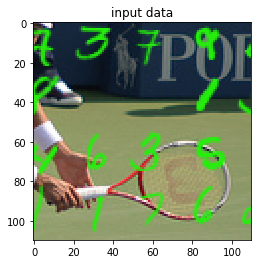

Teaching data


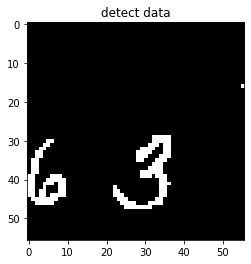

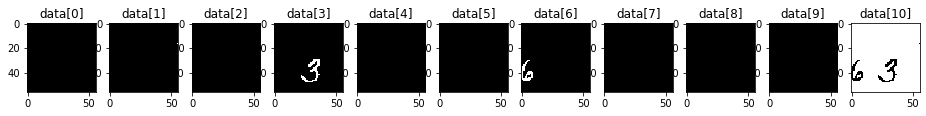

In [14]:
index = 3

# input data
print('Input data')
plt.figure(figsize=(4, 4))
plt.imshow(td['x_train'][index].reshape(3, layer_depth*2+t_height, layer_depth*2+t_width).transpose(1, 2, 0))
plt.title('input data')
plt.show()

# Teaching data
print('Teaching data')
plt.figure(figsize=(4, 4))
plt.imshow(td['d_train'][index].reshape(56, 56), 'gray')
plt.title('detect data')

plt.figure(figsize=(16, 2))
for i in range(11):
    plt.subplot(1, 11, i+1)
    plt.imshow(td['c_train'][index].reshape(11, 56, 56)[i], 'gray')
    plt.title('data[%d]' % i)
plt.show()

# ネットワーク構築

In [15]:
def create_conv_layer(sub_layers, w, h, padding='valid'):
    sub_net = bb.Sequential.create()
    for layer in sub_layers:
        sub_net.add(layer)
    return bb.LoweringConvolutionBit.create(sub_net, w, h, 1, 1, padding=padding)

def create_dense_layer(shape, batch_norm=True):
    sub_net = bb.Sequential.create()
    sub_net.add(bb.DenseAffine.create(shape))
    if batch_norm:
        sub_net.add(bb.BatchNormalization.create())
    sub_net.add(bb.BinarizeBit.create())
    return sub_net

In [16]:
net = bb.Sequential.create()

# input
net.add(bb.BitEncodeBit.create(6, [110, 110, 3*6]))
net.add(create_conv_layer([bb.SparseLut6Bit.create([1, 1, 36*4], batch_norm=False, connection='serial')], 1, 1))

for i in range(27):
#   net.add(create_conv_layer([bb.SparseLut6Bit.create([1, 1, 36*4], batch_norm=False, connection='random')], 1, 1))
#   net.add(create_conv_layer([bb.SparseLut6Bit.create([1, 1, 36*4], batch_norm=True, connection='depthwise')], 3, 3))
#   net.add(create_conv_layer([bb.SparseLut6Bit.create([1, 1, 36],   batch_norm=True, connection='serial')], 1, 1))
    net.add(create_conv_layer([create_dense_layer([1, 1, 36])], 3, 3))

net.add(create_conv_layer([create_dense_layer([1, 1, 11])], 1, 1))

#net.add(create_conv_layer([
#            bb.SparseLut6Bit.create([11*6*6], batch_norm=True, connection='random'),
#            bb.SparseLut6Bit.create([11*6], batch_norm=False, connection='serial'),
#            bb.SparseLut6Bit.create([11], batch_norm=False, connection='serial')
#        ], 1, 1))

# output
net.add(bb.BinaryToRealBit.create())

# set network
net.set_input_shape(td['x_shape'])
net.send_command('binary true')

In [17]:
print(net.get_info())

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [BitEncode] 
   input  shape : {110, 110, 3}   output shape : {110, 110, 18}
   bit_size : 6
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (1, 1)
   input  shape : {110, 110, 18}   output shape : {110, 110, 144}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 18}     output shape : {1, 1, 18}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {1, 1, 18}       output shape : {1, 1, 144}
       binary : 1       batch_norm : 0
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {

In [18]:
mini_batch_size = 16

network_name = 'MnistSegBackgroundClass'
td['t_shape'] = td['c_shape']
td['t_train'] = td['c_train']
td['t_test']  = td['c_test']
loss    = bb.LossSoftmaxCrossEntropy.create()
metrics = bb.MetricsCategoricalAccuracy.create()

#network_name = 'MnistSegBackgroundDetect'
#td['t_shape'] = td['d_shape']
#td['t_train'] = td['d_train']
#td['t_test']  = td['d_test']
#loss    = bb.LossMeanSquaredError.create()
#metrics = bb.MetricsMeanSquaredError.create()

print(net.get_output_shape())
print(td['t_shape'])

optimizer = bb.OptimizerAdam.create()

[56, 56, 11]
[56, 56, 11]


In [19]:
optimizer.set_variables(net.get_parameters(), net.get_gradients())
runner = bb.Runner(net, network_name, loss, metrics, optimizer)

runner.fitting(td, epoch_size=1, mini_batch_size=mini_batch_size, file_write=True, file_read=True)

[load] MnistSegBackgroundClass_net.json


epoch=1 test_accuracy=0.468939 test_loss=5002.718332 train_accuracy=0.474670 train_loss=4999.687594


[[0.46893855564279696,
  5002.718331577539,
  0.47466990098382694,
  4999.687593652296]]

In [21]:
color_table = [
    [0xe6, 0x00, 0x12],  # 0
    [0x92, 0x07, 0x83],  # 1
    [0x1d, 0x20, 0x88],  # 2
    [0x00, 0x68, 0xb7],  # 3
    [0x00, 0xa0, 0xe9],  # 4
    [0x00, 0x9e, 0x96],  # 5
    [0x00, 0x99, 0x44],  # 6
    [0x8f, 0xc3, 0x1f],  # 7
    [0xff, 0xf1, 0x00],  # 8
    [0xf3, 0x98, 0x00],  # 9
    [0x00, 0x00, 0x00],  # BGC
]

def frame_to_image(frame):
    idx_img = np.argmax(frame, axis=0)
    rgb_img = np.ndarray((idx_img.shape[0], idx_img.shape[1], 3), dtype=np.uint8)
    for y in range(idx_img.shape[1]):
        for x in range(idx_img.shape[0]):
            rgb_img[y][x] = color_table[idx_img[y][x]]
    return rgb_img

In [32]:
def plot_image(net, td):
    x_buf = bb.FrameBuffer()
    x_buf.resize(16, td['x_shape'])
    x_buf.set_data(td['x_test'][0:16])
    y_buf = net.forward(x_buf, False)

    x_data = x_buf.get_data(0)
    x_img  = np.array(x_data[0]).reshape(3, 110, 110).transpose(1, 2, 0)
    print(x_img.shape)
    plt.imshow(x_img)
    plt.show()
    
    y_data = y_buf.get_data(0)

    frame = np.array(y_data[0]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))
    plt.show()

(110, 110, 3)


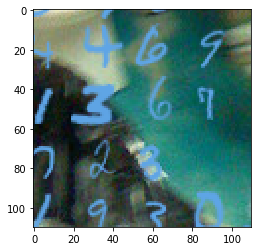

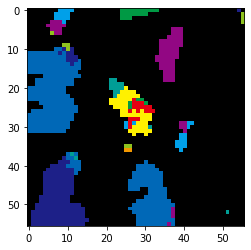

In [33]:
plot_image(net, td)